In [1]:
from imports import cv2, os, np, tf, ImageDataGenerator, plt, pd, requests
import confidential

firebase_url = confidential.get_url()

response = requests.get(firebase_url)

data = response.json()
data_list = [value for key, value in data.items()]

df = pd.DataFrame(data_list)
df = df[["name", "url"]]

def download_image(url, name):
    response = requests.get(url)
    image_data = response.content
    array = bytearray(image_data)

    image = cv2.imdecode(np.asarray(array, dtype=np.uint8), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (180, 180))
    return image

images = []

for index, row in df.iterrows():
    image = download_image(row["url"], row["name"])
    images.append(image)

images = np.array(images)

2024-03-31 00:29:40.370407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 00:29:40.370454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 00:29:40.371269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 00:29:40.376480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 00:29:41.018817: W tensorflow/compiler/tf2

In [2]:
print(images.shape)

(3, 180, 180)


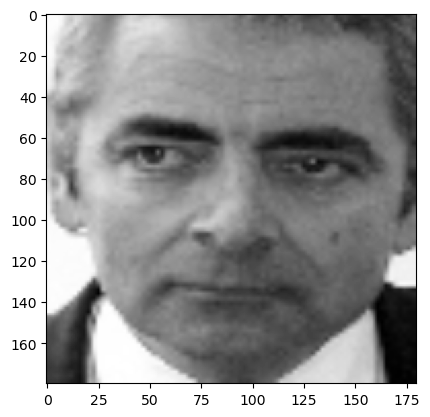

In [3]:
def crop_face(image):
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    if len(faces) == 0:
        return None
    for (x, y, w, h) in faces:
        face = cv2.resize(image[y:y+h, x:x+w], (180, 180))
    return face

faces = []

for image in images:
    face = crop_face(image)
    if face is not None:
        faces.append(face)

faces = np.array(faces)

plt.imshow(faces[0], cmap="gray")

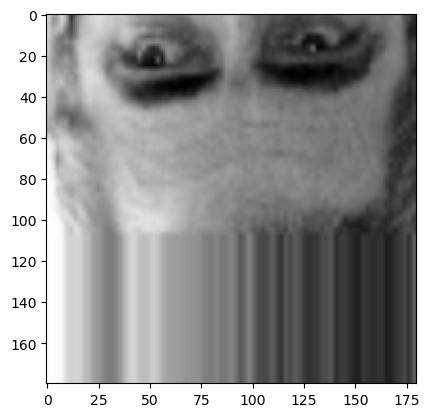

In [4]:
precision = 200

def augment_images(images):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
    augmented_images = []
    for image in images:
        image = np.expand_dims(image, 0)
        i = 0
        for i in range(precision):
            augmented_images.append(train_datagen.random_transform(image))
            i += 1
            if i >= precision:
                break
    return augmented_images

augmented_images = augment_images(faces)
augmented_images = np.array(augmented_images).reshape(-1, 180, 180)
plt.imshow(augmented_images[30], cmap='gray')

In [5]:
labels = df["name"].values
labels = np.repeat(labels, precision)
print(labels)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

['Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean' 'Bean'
 'Bean

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#optimizer is sgd with a learning rate of 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(augmented_images, labels, epochs=12)

Epoch 1/12
19/19 [==============================] - 2s 17ms/step - loss: 24.5327 - accuracy: 0.3833
Epoch 2/12
19/19 [==============================] - 0s 16ms/step - loss: 23.1928 - accuracy: 0.5300
Epoch 3/12
19/19 [==============================] - 0s 16ms/step - loss: 22.8484 - accuracy: 0.6050
Epoch 4/12
19/19 [==============================] - 0s 16ms/step - loss: 22.5087 - accuracy: 0.6833
Epoch 5/12
19/19 [==============================] - 0s 16ms/step - loss: 22.2740 - accuracy: 0.7117
Epoch 6/12
19/19 [==============================] - 0s 16ms/step - loss: 22.0808 - accuracy: 0.7083
Epoch 7/12
19/19 [==============================] - 0s 16ms/step - loss: 21.8598 - accuracy: 0.7417
Epoch 8/12
19/19 [==============================] - 0s 16ms/step - loss: 21.6612 - accuracy: 0.7683
Epoch 9/12
19/19 [==============================] - 0s 16ms/step - loss: 21.4225 - accuracy: 0.8083
Epoch 10/12
19/19 [==============================] - 0s 16ms/step - loss: 21.1719 - accuracy: 0.8867

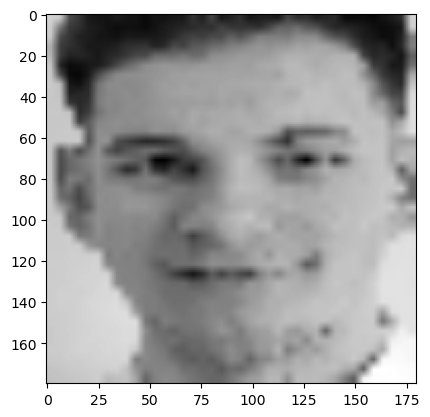

In [27]:
test_image = cv2.imread("fav2.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = cv2.resize(test_image, (180, 180))
test_image = crop_face(test_image)
plt.imshow(test_image, cmap='gray')
test_image = np.expand_dims(test_image, 0)

In [28]:
prediction = model.predict(test_image)
print(prediction)

names = df["name"].unique()

def get_name(prediction):
    idx = np.argmax(prediction)
    return names[idx]

print(get_name(prediction))

1/1 [==============================] - 0s 15ms/step


[[6.8083347e-05 9.9611771e-01 3.8142197e-03]]
Lennart
